In [ ]:
!pip3 install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 9.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import yfinance as yf
import pylab
from arch.unitroot import ADF, KPSS
from arch.unitroot.cointegration import phillips_ouliaris
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen

# Download the price data using yahoo API and transform them into daily return
def downloadData(ticker,start_date,end_date):
    data = yf.download(ticker,start=start_date,end=end_date)
#    data[ticker] = data["Adj Close"].pct_change()
    data[ticker] = data["Adj Close"]
    data.dropna(subset=[ticker], inplace=True)
    data.reset_index(inplace=True)
    ts_data = data.loc[:, ["Date", ticker]].set_index("Date")
    return ts_data

# Download the price for MSFT and AAPL between 2000 and 2022

start_date_ts = "2000-01-01"
end_date_ts = "2022-12-31"

MSFT = downloadData(ticker = "MSFT",start_date=start_date_ts,end_date = end_date_ts)
AAPL = downloadData(ticker = "AAPL",start_date=start_date_ts,end_date = end_date_ts)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


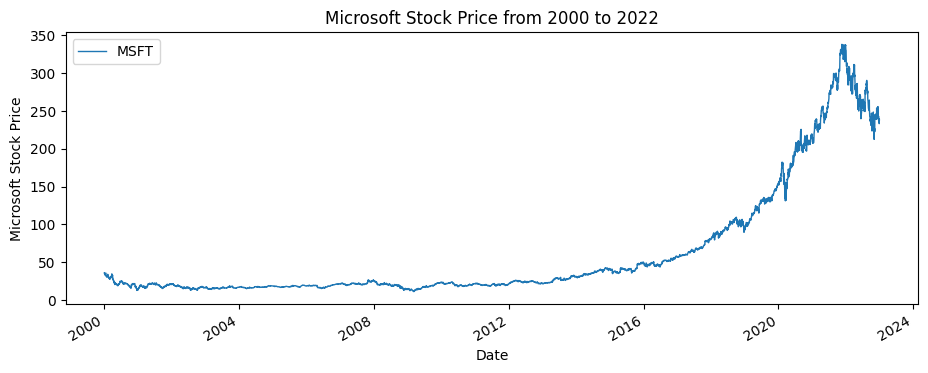

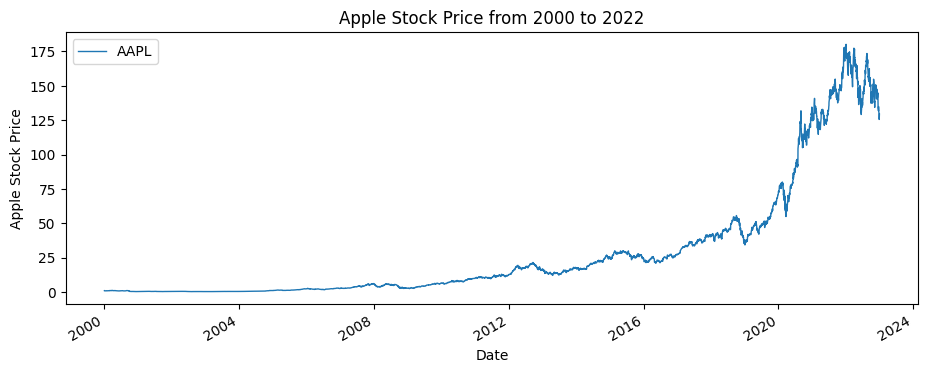

In [ ]:
# Graph of price level for Microsoft and Apple

plt.rcParams["figure.figsize"] = (11, 4)  # Figure size and width

MSFT.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Microsoft Stock Price",
    title="Microsoft Stock Price from 2000 to 2022",
)
plt.show()

AAPL.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Apple Stock Price",
    title="Apple Stock Price from 2000 to 2022",
)
plt.show()


In [ ]:
# Stock Price, ADF Test without drift and trend

MSFT_adf = ADF(MSFT, trend="n", method="bic")
AAPL_adf = ADF(AAPL, trend="n", method="bic")

pd.DataFrame(
    {
        "Microsoft Stock Price": (MSFT_adf.stat, MSFT_adf.critical_values["5%"]),
        "Apple Stock Price": (AAPL_adf.stat, AAPL_adf.critical_values["5%"]),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

Microsoft Stock Price  Apple Stock Price
ADF Test Statistic               1.819198           1.446088
5% Critical Value               -1.941047          -1.941047

In [ ]:
# Stock Price, KPSS Test

print(KPSS(MSFT, trend="ct", lags=-1))

print(KPSS(AAPL, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  3.152
P-value                         0.000
Lags                               34
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  2.767
P-value                         0.000
Lags                               34
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [ ]:
# Two-Step Residual Based Test for Cointegration for Stock Price
print(
    phillips_ouliaris(
        MSFT, AAPL, trend="c", test_type="Za", kernel="bartlett"
    )
)

Phillips-Ouliaris Za Cointegration Test
Statistic: -30.839660583810414
P-value: 0.005486209344385481
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 8.1578
Trend: c
Distribution Order: 3


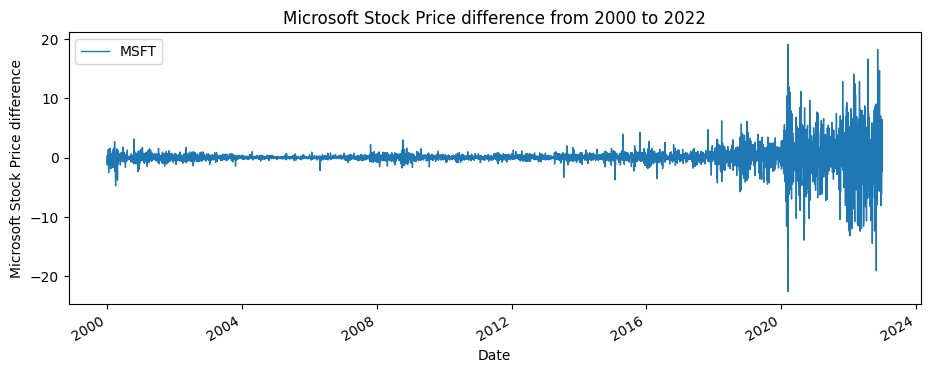

In [ ]:
MSFT_lr = MSFT.diff().dropna()
AAPL_lr= AAPL.diff().dropna()

# Graph of price difference

plt.rcParams["figure.figsize"] = (11, 4)  # Figure size and width

MSFT_lr.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Microsoft Stock Price difference",
    title="Microsoft Stock Price difference from 2000 to 2022",
)
plt.show()

AAPL_lr.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Apple Stock Price difference",
    title="Apple Stock Price difference from 2000 to 2022",
)
plt.show()

In [ ]:
## Stock Price Difference, ADF Test without drift and trend

MSFT_adf = ADF(MSFT_lr, trend="n", method="bic")
AAPL_adf = ADF(AAPL_lr, trend="n", method="bic")

pd.DataFrame(
    {
        "Microsoft Stock Price": (MSFT_adf.stat, MSFT_adf.critical_values["5%"]),
        "Apple Stock Price": (AAPL_adf.stat, AAPL_adf.critical_values["5%"]),
    },
    index=["ADF Test Statistic", "5% Critical Value"],
)

Microsoft Stock Price  Apple Stock Price
ADF Test Statistic             -25.757803         -22.437883
5% Critical Value               -1.941047          -1.941047

In [ ]:
# KPSS

print(KPSS(MSFT_lr, trend="ct", lags=-1))
print(KPSS(AAPL_lr, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.068
P-value                         0.369
Lags                               34
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.
    KPSS Stationarity Test Results   
Test Statistic                  0.052
P-value                         0.550
Lags                               34
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [ ]:
ecm_model = UECM(
    endog=pd.DataFrame(MSFT),
    lags=1,
    exog=pd.DataFrame(AAPL),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

                              UECM Model Results                              
Dep. Variable:                 D.MSFT   No. Observations:                 5787
Model:                     UECM(1, 1)   Log Likelihood               -9365.435
Method:               Conditional MLE   S.D. of innovations             98.323
Date:                Tue, 26 Sep 2023   AIC                          18740.870
Time:                        15:27:11   BIC                          18774.186
Sample:                             1   HQIC                         18752.461
                                 5787                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0441      0.024      1.827      0.068      -0.003       0.091
MSFT.L1       -0.0031      0.001     -2.395      0.017      -0.006      -0.001
AAPL.L1        0.0053      0.002      2.304      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Durbin-Watson Test Result
print(durbin_watson(ecm_model.fittedvalues))

2.1136898054058086
